# Анализ пространственных данных. Домашнее задание №1

Данные для выполнения заданий можно найти [здесь](https://yadi.sk/d/xBemeb0ODlhCAQ?w=1)

Дедлайн: __20 октября 2020 г. 09:00__

ФИО: `Черкасов Роман Владиславович`

Группа: `MADE-DS-12`

## Задание №1. Reading coordinates from a file and creating a geometries. 4 балла.

One of the "classical" problems in GIS is the situation where you have a set of coordinates in a file and you need to get them into a map (or into a GIS-software). Dataset `travelTimes_2015_Helsinki.txt` consist of travel times between specific locations in Helsinki Region.

1. Read the data into memory.
2. Read 4 columns `from_x`, `from_y`, `to_x`, `to_y` from the data.
3. Create two lists called __orig_points__ and __dest_points__
4. Iterate over the rows of your numpy array and add Shapely Point -objects into the __orig_points__ -list and __dest_point__ -list representing the origin locations and destination locations accordingly.

`from_x`: x-coordinate of the __origin__ location (longitude)

`from_y`: y-coordinate of the __origin__ location (latitude)

`to_x`: x-coordinate of the __destination__ location (longitude)

`to_y`: y-coordinate of the __destination__ location (latitude)

In [ ]:
# put your code here

# for google colab
!pip install --upgrade geopandas

#for google colab
from google.colab import drive
drive.mount('/content/drive')

WORK_DIR = "/content/drive/My Drive/portflio/geo/HW1/HW1_data/"

import geopandas as gpd

travel_times = gpd.read_file(WORK_DIR+"travelTimes_2015_Helsinki.csv",)
travel_times = travel_times[["from_x","from_y","to_x","to_y"]]

orig_points = list(gpd.points_from_xy(
  travel_times["from_x"], 
  travel_times["from_y"]
))

dest_points = list(gpd.points_from_xy(
  travel_times["to_x"], 
  travel_times["to_y"]
))

     |████████████████████████████████| 972kB 2.7MB/s 
     |████████████████████████████████| 10.9MB 10.3MB/s 
     |████████████████████████████████| 14.8MB 260kB/s 
Mounted at /content/drive


## Задание №2. Creating LineStrings that represent the movements. 6 баллов.

Please use data from previous task:

1. Create a list called `lines`
2. Iterate over the __orig_points__ and __dest_points__ lists and create a Shapely _LineString_ -object between the origin and destination point
3. Add that line into the `lines` -list.
4. Find out what is the average (Euclidian) distance of all the origin-destination _LineStrings_ that we just created, and print it out.

In [ ]:
# put your code here

from shapely.geometry import LineString
import numpy as np

lines = [
  LineString((p_from, p_to)) for p_from, p_to in zip(
    orig_points, 
    dest_points
  )
]
avg_dist = np.mean([x.length for x in lines])
print(f"average distance: {avg_dist}")

average distance: 0.21502224823227248


## Задание №3. Points to map. 4 балла.

Aim is to plot a set of x and y coordinates that we should read from a `some_posts.csv`. The data has 81379 rows and consists of locations and times of social media posts inside Kruger national park in South Africa.

1. Read the data into memory.
2. Create an empty column called `geometry` where you will store shapely _Point_ objects
3. Iterate over the rows of the DataFrame (__x__ and __y__ -coordinates) and insert _Point_ objects into column `geometry`
4. Convert that DataFrame into a GeoDataFrame
5. Update the CRS for coordinate system as WGS84 (i.e. epsg code: 4326)
6. Save the data into a Shapefile called `Kruger_posts.shp`
7. Create a simple map of those points using .plot() -funtion

`lat`: y-coordinate of the post

`lon`: x-coordinate of the post

`timestamp`: Time when the post was uploaded

`userid`: userid

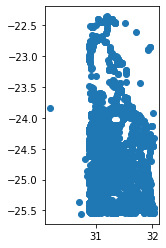

In [ ]:
# put your code here

from shapely.geometry import Point

d_posts = gpd.pd.read_csv(WORK_DIR+"some_posts.csv") # step 1
d_posts["geometry"] = None #step 2
d_posts["geometry"] = d_posts.apply(
  lambda row: Point(row["lon"], row["lat"]),
  axis=1
) # step 3
gd_posts = gpd.GeoDataFrame(
  d_posts[[c for c in d_posts.columns if c!="geometry"]],
  geometry = d_posts["geometry"]
) # step 4
gd_posts["geometry"] = gd_posts.geometry.set_crs(epsg=4326) # step 5
gd_posts.to_file(WORK_DIR + "Kruger_posts.shp") # step 6
gd_posts.plot() # step 7


## Задание №4. Movements of individual user. 6 баллов.

Please use data from previous task:

1. Group the data by `userid`
2. Create an empty GeoDataFrame
3. For each user:
   - sort the rows by `timestamp`
   - create _LineString_ objects based on the points
   - add the `geometry` and the `userid` into the GeoDataFrame you created in the last step
4. Determine the CRS of your GeoDataFrame to WGS84 (epsg code: 4326)
5. Save the movements of each user into a separate Shapefile
   - Name the output Shapefile based on the `userid` number

In [ ]:
# put your code here
import os

gd_posts_byUserid = gd_posts.sort_values(
    ["timestamp", "userid"]
).groupby(by="userid") # step 1 + sorting from step 3
geo_df = gpd.GeoDataFrame({"userid":[],"geometry":[]}) # step 2
geo_df["userid"] = geo_df.userid.astype(int)

#step 3
for userid, df in gd_posts_byUserid:
  lst = df.geometry.to_list()
  if len(lst)>1:
    line = LineString(lst)
    geo_df = geo_df.append({"userid":userid,"geometry":line},ignore_index=True)

geo_df = geo_df.set_crs(epsg=4326) # step 4

#step 5
# os.mkdir(WORK_DIR+"/userid/")
for i, userid in enumerate(sorted(geo_df.userid.unique())):
  df = geo_df.loc[geo_df.userid==userid]
  df.to_file(WORK_DIR+"/userid/"+f"{userid}.shp")
  if i>5:
    break


## Задание №5. Join accessibility datasets into a grid and visualize them by using a classifier. 4 балла.

A dataset from `dataE4.zip` includes 7 text files containing data about accessibility in Helsinki Region and a Shapefile that contains a Polygon grid that can be used to visualize and analyze the data spatially. The datasets are:

 - `travel_times_to_[XXXXXXX]_[NAME-OF-THE-CENTER].txt` including travel times and road network distances to specific shopping center
 - `MetropAccess_YKR_grid_EurefFIN.shp` including the Polygon grid with __YKR_ID__ column that can be used to join the grid with the accessibility data
 
Find out more about the data [here](https://blogs.helsinki.fi/accessibility/helsinki-region-travel-time-matrix-2015/)

1. Read those travel_time data files (one by one) with Pandas and select only following columns from them:

 - `pt_r_tt`
 - `car_r_t`
 - `from_id`
 - `to_id`


2. Visualize the classified travel times (Public transport AND Car) of at least one of the shopping centers using any classification method (see [PySAL](https://pysal.org/) for more details upon classification methods). You need to classify the data into a new column in your GeoDataFrame.

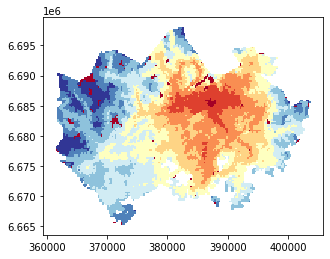

In [ ]:
# put your code here
df_list = []
for fname in os.listdir(WORK_DIR+"dataE4/"):
  if fname.endswith(".txt"):
    fpath = WORK_DIR+"dataE4/"+fname
    df = gpd.pd.read_csv(
        fpath,sep=";", 
        # names=["pt_r_tt", "car_r_t", "from_id", "to_id"],
        # header=0
    )
    df = df[["pt_r_tt", "car_r_t", "from_id", "to_id"]]
    df["fname"] = fname
    df_list.append(df)

d_e7 = gpd.pd.concat(df_list)
shp = gpd.read_file(WORK_DIR+"dataE4/MetropAccess_YKR_grid_EurefFIN.shp")

d_merged = d_e7.merge(shp, left_on=["from_id"], right_on=["YKR_ID"])
gd_merged = gpd.GeoDataFrame(
    d_merged,
    geometry=d_merged["geometry"]
)
!pip install -q -U mapclassify

gd_merged[gd_merged.fname=="TravelTimes_to_5878070_Jumbo.txt"].plot(
    column="pt_r_tt", 
    scheme="Natural_Breaks", 
    k=9, cmap="RdYlBu", 
    linewidth=0, 
    legend=False
  )

## Задание №6. Calculate and visualize the dominance areas of shopping centers. 6 баллов.

Please use data from previous task. The aim is to define the dominance area for each of those shopping centers based on travel time:

1. Iterate over the accessibility files one by one
2. Rename the travel time columns so that they can be identified
   - you can include e.g. the `to_id` number as part of the column name (then the column name could be e.g. "pt_r_tt_5987221")
3. Join those columns into `MetropAccess_YKR_grid_EurefFIN.shp` where __YKR_ID__ in the grid corresponds to `from_id` in the travel time data file. At the end you should have a GeoDataFrame with different columns show the travel times to different shopping centers.
4. For each row find out the __minimum__ value of __all__ `pt_r_tt_XXXXXX` columns and insert that value into a new column called `min_time_pt`. You can now also parse the `to_id` value from the column name (i.e. parse the last number-series from the column text) that had the minimum travel time value and insert that value as a number into a column called `dominant_service`. In this, way are able to determine the "closest" shopping center for each grid cell and visualize it either by travel times or by using the __YKR_ID__ number of the shopping center (i.e. that number series that was used in column name).
5. Visualize the travel times of our `min_time_pt` column using any classifier.
6. Visualize also the values in `dominant_service` column (no need to use any specific classifier). Notice that the value should be a number. If it is still as text, you need to convert it first.

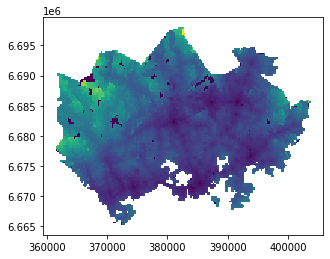

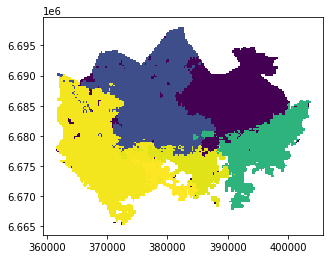

In [ ]:
# put your code here

df_list = []
# step 1
for fname in os.listdir(WORK_DIR+"dataE4/"):
  if fname.endswith(".txt"):
    fpath = WORK_DIR+"dataE4/"+fname
    df = gpd.pd.read_csv(
        fpath,sep=";", 
        # names=["pt_r_tt", "car_r_t", "from_id", "to_id"],
        # header=0
    ) # step 1
    df = df[["pt_r_tt", "car_r_t", "from_id", "to_id"]]
    df["fname"] = fname
    df.rename(columns={})
    df = df[["pt_r_tt", "from_id"]].rename(
      columns={
        "pt_r_tt": f"pt_r_tt_{df.loc[df.to_id>=0, 'to_id'][0]}"
      }
    ) # step 2
    df_list.append(df)

shp = gpd.read_file(WORK_DIR+"dataE4/MetropAccess_YKR_grid_EurefFIN.shp")

# step 3
d_merged = shp
for df in df_list:
  d_merged = d_merged.merge(
      df, left_on=["YKR_ID"], right_on=["from_id"]
  )

d_merged["min_time_pt"] = d_merged[
  [c for c in d_merged.columns if c.startswith("pt_r_tt_")]
].min(axis=1) # step 5

d_merged["dominant_service"] = d_merged[
  [c for c in d_merged.columns if c.startswith("pt_r_tt_")]
].idxmin(axis=1).str.replace("pt_r_tt_", "").astype(int) # step 6

gd_merged = gpd.GeoDataFrame(
    d_merged,
    geometry=d_merged["geometry"]
)

d_merged.plot(column="min_time_pt")
d_merged.plot(column="dominant_service")

# попытка экспорта в html или pdf

In [ ]:
!apt-get install texlive texlive-xetex texlive-latex-extra pandoc
!pip install pypandoc

Reading package lists... Done
Building dependency tree       
Reading state information... Done
pandoc is already the newest version (1.19.2.4~dfsg-1build4).
pandoc set to manually installed.
The following additional packages will be installed:
  fonts-droid-fallback fonts-lato fonts-lmodern fonts-noto-mono fonts-texgyre
  javascript-common libcupsfilters1 libcupsimage2 libgs9 libgs9-common
  libijs-0.35 libjbig2dec0 libjs-jquery libkpathsea6 libpotrace0 libptexenc1
  libruby2.5 libsynctex1 libtexlua52 libtexluajit2 libzzip-0-13 lmodern
  poppler-data preview-latex-style rake ruby ruby-did-you-mean ruby-minitest
  ruby-net-telnet ruby-power-assert ruby-test-unit ruby2.5
  rubygems-integration t1utils tex-common tex-gyre texlive-base
  texlive-binaries texlive-fonts-recommended texlive-latex-base
  texlive-latex-recommended texlive-pictures texlive-plain-generic tipa
Suggested packages:
  fonts-noto apache2 | lighttpd | httpd poppler-utils ghostscript
  fonts-japanese-mincho | fonts-ipa

In [ ]:
!jupyter nbconvert --to PDF "/content/drive/My Drive/portflio/geo/HW1/HW1.ipynb"

[NbConvertApp] Converting notebook /content/drive/My Drive/portflio/geo/HW1/HW1.ipynb to PDF
[NbConvertApp] Support files will be in HW1_files/
[NbConvertApp] Making directory ./HW1_files
[NbConvertApp] Making directory ./HW1_files
[NbConvertApp] Making directory ./HW1_files
[NbConvertApp] Making directory ./HW1_files
[NbConvertApp] Writing 74083 bytes to ./notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: [u'xelatex', u'./notebook.tex', '-quiet']
[NbConvertApp] Running bibtex 1 time: [u'bibtex', u'./notebook']
[NbConvertApp] WARNING | bibtex had problems, most likely because there were no citations
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 122938 bytes to /content/drive/My Drive/portflio/geo/HW1/HW1.pdf
